In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

### Datasets

In [2]:
def load_data_arrays():
    df_1 = pd.read_csv("../../datasets/1_no_stopwords.csv")
    df_3 = pd.read_csv("../../datasets/3_no_stopwords.csv")
    df_5 = pd.read_csv("../../datasets/5_no_stopwords.csv")
    df_6 = pd.read_csv("../../datasets/6_no_stopwords.csv")
    
    df = df_1.append(df_3)
    df = df.append(df_5)
    df = df.append(df_6)

    df = df[(df['is_hatespeech'] == 1)]
    df = df[(df['class'] != 0)]
    df = df[(df['class'] != 6)]
    df = df[(df['class'] != 7)]
    
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df["is_hatespeech"])
    
    return train_df, test_df

train_df, test_df = load_data_arrays()


# Convert the test- and train-DataFrames to Tensorflow Datasets

train_labels = np.eye(6)[train_df['class'].values]
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(train_df['text'].values, dtype=str), tf.string),
            tf.cast(train_labels, tf.int32)
        )
    )
)

test_labels = np.eye(6)[test_df['class'].values]
test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(test_df['text'].values, dtype=str), tf.string),
            tf.cast(test_labels, tf.int32)
        )
    )
)

BUFFER_SIZE = 1000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [3]:
print(train_dataset)
print(train_labels[0])

<PrefetchDataset shapes: ((None,), (None, 6)), types: (tf.string, tf.int32)>
[0. 1. 0. 0. 0. 0.]


### Keywords feature

In [4]:
df_kw = pd.read_csv("../../datasets/bad_words.csv")
kw_vocab = set()
for idx, item in df_kw.iterrows():
  kw_vocab.add(item[0])
kw_vocab_len = len(kw_vocab) + 1
kw_layer = tf.keras.layers.TextVectorization(vocabulary=list(kw_vocab))
kw_layer.compile()

### Model

In [6]:
import tensorflow.keras.layers as layers

input_layer = layers.Input(shape=(1,), dtype=(tf.string))
seq_layer = kw_layer(input_layer)
seq_layer = layers.Embedding(input_dim=len(kw_layer.get_vocabulary()), output_dim=64, mask_zero=True)(seq_layer)
seq_layer = layers.Bidirectional(tf.keras.layers.LSTM(64))(seq_layer)
seq_layer = layers.Dense(64, activation='relu')(seq_layer)
output_layer = layers.Dense(6, activation='softmax')(seq_layer)

model = tf.keras.Model(name="hatespeech_keywords", inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(0.0075), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(train_dataset, epochs=5, validation_data=test_dataset, validation_steps=5)

Epoch 1/5
111/111 [==============================] - 14s 64ms/step - loss: 0.8431 - accuracy: 0.6589 - val_loss: 0.7023 - val_accuracy: 0.7406
Epoch 2/5
111/111 [==============================] - 5s 48ms/step - loss: 0.6209 - accuracy: 0.7813 - val_loss: 0.6317 - val_accuracy: 0.7594
Epoch 3/5
111/111 [==============================] - 5s 44ms/step - loss: 0.5870 - accuracy: 0.7938 - val_loss: 0.6183 - val_accuracy: 0.7594
Epoch 4/5
111/111 [==============================] - 5s 46ms/step - loss: 0.5744 - accuracy: 0.7979 - val_loss: 0.6474 - val_accuracy: 0.7656
Epoch 5/5
111/111 [==============================] - 5s 45ms/step - loss: 0.5624 - accuracy: 0.7989 - val_loss: 0.6534 - val_accuracy: 0.7625


In [7]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

28/28 [==============================] - 1s 23ms/step - loss: 0.6629 - accuracy: 0.7556
Test Loss: 0.6628754138946533
Test Accuracy: 0.755630612373352


Plot the results

(0.0, 0.8570940226316452)

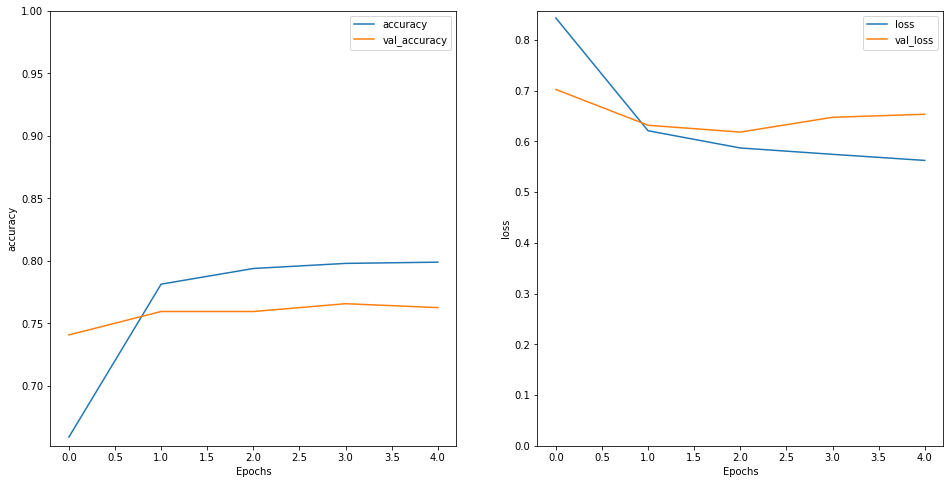

In [8]:
np.set_printoptions(precision=3, suppress=True)

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [9]:
# predict on a sample text without padding.
sample_text = ['You are such a stupid fucking whore',
               'I would not recommend this movie.']
predictions = model.predict(np.array(sample_text))
print(predictions)

[[0.    0.26  0.009 0.037 0.677 0.017]
 [0.    0.427 0.006 0.058 0.495 0.013]]


(Optional) Save the model

In [10]:
# model_two.save('saves/keywords')